#Hello This Notebook contains progress in GANs 
## 1- Data Preprocessing

**Folder Tain_Data https://drive.google.com/drive/folders/1AT9auHBTlv01iKocCsbRXS8Pfw5noOAS?usp=sharing** 
conatins multiple important folders


1.   Original Folder contains 3000 jpg images collected from different resources.
2.   Target Folder contains 2946 jpg images after passing through Collector Code (Colab has been crashed many times so I worked on 2946 ).

3. Resized_original Folder Contains rezied  original images (600x600)

4. Resized_target Folder Contains rezied  target images (600x600)

5. Merged Folder  Contains rezied  Merged images (1200x1200) like this to apply them to arch

For summary now, we have Merged Folder conatins paired images (original and target) to use them in pix2pix arch.





##2- GANs Architecture 





This is used to check how many images in specific folder

In [ ]:
import os
#len(os.listdir())
len(os.listdir('/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Merged')) 

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GANs Architecture (Under Processing)



* 1- install and import dependencies 
**Albumentations** is a Python library for fast and flexible image augmentations.

In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2
import torch
torch.cuda.is_available()

     |████████████████████████████████| 117 kB 10.2 MB/s 
     |████████████████████████████████| 948 kB 43.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ff4e142874eb013ed26b097e8064ac024c8c60a0aa6162f2172b748672ca5e7b
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


True

In [ ]:
ls

drive/  sample_data/


* 2- set some paramaters

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2 ##to convert to tensor

"""Check current device is GPU"""
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


""" Add folder path of Train images and test images """
TRAIN_DIR = "/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Merged"
#VAL_DIR = "/content/drive/MyDrive/graduation_project/DATASET/val"

LEARNING_RATE = 2e-4
BATCH_SIZE = 1
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3

L1_LAMBDA = 100
LAMBDA_GP = 10

NUM_EPOCHS = 200

LOAD_MODEL = False
SAVE_MODEL = True

CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"


* 3- Create class for loading dataset in PyTorch   **(Need to Change like repo )**

In [ ]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset , DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms

"""Building Efficient Custom Datasets in PyTorch """
class MapDataset(Dataset): 
  
  """ Get and Save the directory of origianl and Target Images
  """
  def __init__(self, root_dir):
    self.root_dir = root_dir #which is merged which contains (Original and Target)
    self.list_files = os.listdir(self.root_dir)
  
  """Return the size of the dataset"""
  def __len__(self):
    return len( self.list_files)

  """Return a sample from the dataset given an index."""
  def __getitem__(self, index):
    
    img_file = self.list_files[index]
    img_path = os.path.join(self.root_dir, img_file)
    image = np.array(Image.open(img_path))
    input_image = image[:, :600, :]
    target_image = image[:, 600:, :]

    """Image Augmentation """
    both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"}, ##support 2 input images
    )
    
    transform_only_input = A.Compose(
    [A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
    )

    transform_only_mask = A.Compose(
    [ A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
    )

    """Apply Augmentation on original and target images"""
    augmentations = both_transform(image=input_image, image0=target_image)
    input_image = augmentations["image"]
    target_image = augmentations["image0"]
    
    input_image = transform_only_input(image=input_image)["image"]
    target_image = transform_only_mask(image=target_image)["image"]

    return input_image, target_image
'''
from google.colab.patches import cv2_imshow
if __name__ == "__main__":
    dataset = MapDataset("/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data")
    loader = DataLoader(dataset, batch_size=5)
    #print(len (loader))
    for x, y in loader:
        #print(x.shape)
        save_image(x, "x.png")
        save_image(y,"y.png")
        img1=cv2.imread('x.png')
        img2=cv2.imread('y.png')
        cv2_imshow(np.hstack([np.float32(img1), np.float32(img2)]))
'''

'\nfrom google.colab.patches import cv2_imshow\nif __name__ == "__main__":\n    dataset = MapDataset("/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data")\n    loader = DataLoader(dataset, batch_size=5)\n    #print(len (loader))\n    for x, y in loader:\n        #print(x.shape)\n        save_image(x, "x.png")\n        save_image(y,"y.png")\n        img1=cv2.imread(\'x.png\')\n        img2=cv2.imread(\'y.png\')\n        cv2_imshow(np.hstack([np.float32(img1), np.float32(img2)]))\n'

* 4- Disriminator Architecture

the discriminator outputs a one-channel matrix of classifications
instead of a single value.


Your discriminator's final layer will simply map from the final number of hidden channels to a single prediction for every pixel of the layer before it.


In [ ]:
import torch
import torch.nn as nn

"""Create CNN Arch to use it later"""
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        
        """Create Sequnetial Model"""
        self.conv = nn.Sequential(
            nn.Conv2d(  ##Apply a 2D convolution 
                in_channels, out_channels, 2, stride, bias=False ),
                nn.BatchNorm2d(out_channels), ##Apply BatchNormalization
                nn.LeakyReLU(0.2), ##Activation Function. It is recommended in GANs
        )

    def forward(self, x):
        return self.conv(x)

"""Create discriminator Arch"""
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        
        """Initial Layer"""
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=2,
                stride=2),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=2, stride=1  ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

'''
def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)


if __name__ == "__main__":
    test()'''

'\ndef test():\n    x = torch.randn((1, 3, 256, 256))\n    y = torch.randn((1, 3, 256, 256))\n    model = Discriminator(in_channels=3)\n    preds = model(x, y)\n    print(model)\n    print(preds.shape)\n\n\nif __name__ == "__main__":\n    test()'

* 5- Generator Arch

### U_NET (UP & DOWN SAMPLING )
Values:

*input_channels: the number of channels to expect from a given input

*output_channels: the number of channels to expect for a given output



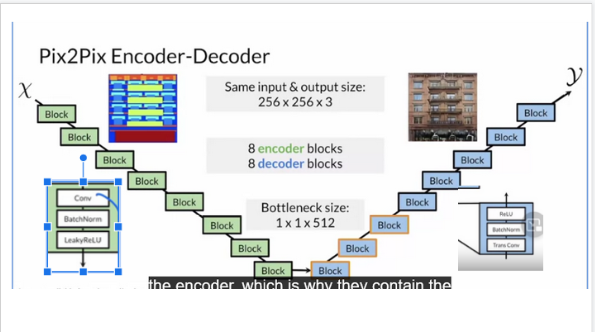

In [ ]:
import torch
import torch.nn as nn


class U_Net(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(U_Net, self).__init__()
        self.conv = nn.Sequential(
          ###DOWN SAMPLING#####
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
          ####UP SAMPLING ####
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
########## USED FOR ADDING NOISE TO ENSURE THAT THE OUTPUT AREN'T THE SAME FOR ALL SAMPLES #########
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        """Create Initial CNN Layer"""
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 2, 2),
            nn.LeakyReLU(0.2),
        )
        """Create blocks of Encoder layers"""
        self.down1 = U_Net(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = U_Net(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = U_Net(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = U_Net(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = U_Net(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = U_Net(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )

        """Bottleneck Layer"""
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 2, 2), nn.ReLU()
        )

        """Create Blocks of Decoder"""
        self.up1 = U_Net(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = U_Net(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = U_Net(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = U_Net(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = U_Net(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = U_Net(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = U_Net(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=2, stride=2),
            nn.Tanh(),
        )
    '''
       forward is a Function for completing a forward pass of UP AND DOWN SAMPLING : 
        Given an image tensor, RETURN THE NEW TENSOR WITH THE SAME DIMS OF FIRST ONE
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
'''

    def forward(self, x):
  
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

'''
if __name__ == "__main__":
    test()'''

'\nif __name__ == "__main__":\n    test()'

* 6- Implement Hepler functions to save some examples **Need to Handle save_examples function**

In [ ]:
import torch
from torchvision.utils import save_image
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from PIL import Image


def save_some_examples(gen, train_loader, epoch, folder):
    x, y = next(iter(train_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)

    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        # remove normalization#
        y_fake = y_fake * 0.5 + 0.5  
        x=x * 0.5 + 0.5
        y= y * 0.5 + 0.5
        # save images in evaluation folder 
        save_image(y_fake, folder + f"/y_gen_{epoch}.jpg")
        save_image(x , folder + f"/input_{epoch}.jpg")
        save_image(y, folder + f"/target_{epoch}.jpg")

        ## plot images together for better visualization 
        #create figure
        fig = plt.figure(figsize=(60, 60))
        # setting values to rows and column variables
        rows = 2
        columns = 2
        # reading images
        Image1 = cv2.imread(folder + f"/input_{epoch}.jpg") # Original 
        Image1=cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
        Image1= cv2.resize(Image1, (400,400))

        Image2 = cv2.imread(folder+ f"/y_gen_{epoch}.jpg") # generated 
        Image2=cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
        Image2= cv2.resize(Image2, (400,400))

        Image3 = cv2.imread(folder + f"/target_{epoch}.jpg") # target 
        Image3=cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB) 
        Image3= cv2.resize(Image3, (400,400))

        
        ##Adds a subplot at the 1st position "original"
        fig.add_subplot(rows, columns, 1)
        # showing image
        plt.imshow(Image1)
        plt.axis('off')
        plt.title("Original") 

        # Adds a subplot at the 2nd position "generated "
        fig.add_subplot(rows, columns, 2) 
        # showing image
        plt.imshow(Image2)
        plt.axis('off')
        plt.title("generated")    
        # Adds a subplot at the 3nd position ""Target 
        fig.add_subplot(rows, columns, 3) 
        # showing image
        plt.imshow(Image3)
        plt.axis('off')
        plt.title("target")     

         # save the final figure in 'final_data' folder            
        plt.savefig("/content/drive/MyDrive/GANs/ADAS_Dataset/Final_Output"+f"/out_{epoch}.jpg")


        ###Get diff between Target and generated images and save in txt file
        
        Image_Target_Gray = cv2.imread(folder + f"/target_{epoch}.jpg") #  
        Image_Target_Gray=cv2.cvtColor(Image_Target_Gray, cv2.COLOR_BGR2GRAY)

        Image_Generated_Gray = cv2.imread(folder + f"/y_gen_{epoch}.jpg") #  
        Image_Generated_Gray=cv2.cvtColor(Image_Generated_Gray, cv2.COLOR_BGR2GRAY)

        difference = cv2.absdiff(Image_Target_Gray, Image_Generated_Gray)

        #print(difference)
        num_diff = cv2.countNonZero(difference)
        print(num_diff)
        f = open("/content/drive/MyDrive/GANs/ADAS_Dataset/Diff_Values/"+f"/epoch{epoch}.txt", "w")
        f.write(str(difference))
        f.write(str(num_diff))
        f.close()



    gen.train()



def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


* Train **(Need to Check this cell again)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim # for progress tracking using trackbar 
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
import cv2
torch.backends.cudnn.benchmark = True
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,):
    
    loop = tqdm(loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        #print("loop", len(loop))
       
        #for i in range (len(loop)):
          
        #save_image(x , "/content/drive/MyDrive/GANs/ADAS_Dataset/generated" + f"/input_{idx}.jpg")
        #save_image(y , "/content/drive/MyDrive/GANs/ADAS_Dataset/generated" + f"/target_{idx}.jpg")
          #np.hstack([np.array(x), np.array(y)])


        
        #print ("x is" , len(x))
        #print ("y is" , len(y))
        
        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2  ## we divided by 2 to make disc train slower than gen 

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )


def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()
   
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE, )
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc,LEARNING_RATE, )
   
    train_dataset = MapDataset(root_dir=TRAIN_DIR) ###################################3
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    

    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    #val_dataset = MapDataset(root_dir=VAL_DIR) ########################################
    #val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


    for epoch in range(NUM_EPOCHS):
        gen.cuda()
        disc.cuda()
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        )
        save_some_examples(gen, train_loader, epoch, folder="/content/drive/MyDrive/GANs/ADAS_Dataset/evaluation")

if __name__ == "__main__":
    main()

100%|██████████| 2940/2940 [07:01<00:00,  6.98it/s, D_fake=0.0831, D_real=0.993]


62001


100%|██████████| 2940/2940 [06:09<00:00,  7.96it/s, D_fake=0.174, D_real=0.942]


58397


100%|██████████| 2940/2940 [06:09<00:00,  7.97it/s, D_fake=0.00144, D_real=0.96]


62458


100%|██████████| 2940/2940 [06:03<00:00,  8.09it/s, D_fake=0.0779, D_real=0.985]


55572


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.372, D_real=0.569]


58870


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.109, D_real=0.876]


57575


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.00208, D_real=0.996]


54642


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.0352, D_real=0.971]


52096


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.0408, D_real=0.986]


51436


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.018, D_real=0.577]


55897


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.00785, D_real=0.982]


56508


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.0709, D_real=0.835]


51977


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.00177, D_real=0.937]


51967


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.183, D_real=0.881]


54699


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.0238, D_real=0.746]


53135


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.0154, D_real=0.561]


60804


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.0349, D_real=0.925]


56253


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.0947, D_real=0.845]


58068


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.0197, D_real=0.601]


57002


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.0382, D_real=0.838]


56333


100%|██████████| 2940/2940 [06:02<00:00,  8.10it/s, D_fake=0.0131, D_real=0.623]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


57437


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.00266, D_real=0.902]


55098


100%|██████████| 2940/2940 [06:02<00:00,  8.11it/s, D_fake=0.0748, D_real=0.959]


51866


100%|██████████| 2940/2940 [06:02<00:00,  8.12it/s, D_fake=0.00533, D_real=0.667]


54713


100%|██████████| 2940/2940 [06:02<00:00,  8.12it/s, D_fake=0.00898, D_real=0.591]


57319


100%|██████████| 2940/2940 [06:02<00:00,  8.12it/s, D_fake=0.0242, D_real=0.747]


56426


100%|██████████| 2940/2940 [06:02<00:00,  8.12it/s, D_fake=0.0484, D_real=0.97]


51623


100%|██████████| 2940/2940 [06:02<00:00,  8.12it/s, D_fake=0.0291, D_real=0.951]


55775


 46%|████▌     | 1348/2940 [02:46<03:14,  8.20it/s, D_fake=0.00806, D_real=0.737]

####trails

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/GANs/ADAS_Dataset/evaluation/target_0.jpg',0)
img2 = cv2.imread('/content/drive/MyDrive/GANs/ADAS_Dataset/evaluation/target_0.jpg',0)
#img1=cv2.cvtColor(img1, cv2.CV_RGB2GRAY)
#img2=cv2.cvtColor(img2, cv2.CV_RGB2GRAY)

difference = cv2.absdiff(img1, img2)
#print(img1)
#print(img2)
print(difference)
num_diff = cv2.countNonZero(difference)
print(num_diff)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0


In [ ]:
import cv2
img= cv2.imread('/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Resized_original/resized1000.jpg')
dimensions = img.shape
print(dimensions)

(600, 600, 3)


In [ ]:
pwd

'/content'

In [ ]:
f = open("epoch1.txt", "w")
f.write(str(difference))
f.write(str(num_diff))

f.close()

#open and read the file after the appending:
f = open("epoch1.txt", "r")
print(f.read())

[[11  1  6 ...  9 11 25]
 [ 1 18 10 ...  7 14  3]
 [ 5 15 21 ...  6 28 21]
 ...
 [30 32 18 ...  9  6 12]
 [18  1  5 ...  9 14  6]
 [19  3 12 ... 13 10  4]]62189


#Data Processing Trails



*   try to resize and save


In [ ]:
img= cv2.imread(f"/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Target/3129.jpg")
img2= cv2.resize(img,(600,600))
cv2.imwrite (f"/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Resized_target/resized3129.jpg",img2)

True



*   Loop to resize all orignal and target images and save them


In [ ]:
#1076 to 1129 not found in target 
for i in range (2945,3129):
  img= cv2.imread(f"/content/drive/MyDrive/graduation_project/DATASET/Train_Data/Target/{i}.jpg")
  img2= cv2.resize(img,(600,600))
  cv2.imwrite (f"/content/drive/MyDrive/graduation_project/DATASET/Train_Data/Resized_target/resized{i}.jpg",img2)




*   Merge orignial and target in one image and save them



In [ ]:
import glob  
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

i=0
for i in range (1130,3130):

  Image1 = cv2.imread(f'/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Resized_original/resized{i}.jpg')
 
  Image2 = cv2.imread(f'/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Resized_target/resized{i}.jpg')


  final =np.hstack([np.float32(Image1), np.float32(Image2)])
  cv2.imwrite (f"/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Merged/merged_{i}.jpg",final)
  print("done")
  #cv2_imshow(final)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done




*   Corrector Code which generate target images



In [ ]:
##########################################################################################
import os

# Paths of all folders in the given directory
directory = '/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Original'
output_path = '/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Target2'
package_path = "/content/daltonize.py"


mormal_imgs_folders = [x[0] for x in os.walk(directory)]


for folder_path in mormal_imgs_folders:
    # Output paths
    folder_name = folder_path.split("/")[-1]
    output_folder_bp = output_path   # brettle_protanopia
    
    if not os.path.exists(output_folder_bp): os.makedirs(output_folder_bp)
    
    # Correct Images
    for img_name in os.listdir(folder_path):
        # Make sure if the file is an image
        if img_name.endswith(('.jpg', '.png', '.jpeg')):
            # Make the final path of the image
            input_path = os.path.join(folder_path, img_name)
            output_path_bp = os.path.join(output_folder_bp, img_name)

            # daltonize package (brettle Model - LMS Daltonization)
            !python3 $package_path -d -t p -g 2.4 $input_path $output_path_bp

python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Errno 2] No such file or directory
python3: can't open file '/content/daltonize.py': [Err

KeyboardInterrupt: ignored



*   Final test on merged images to able to use them in model


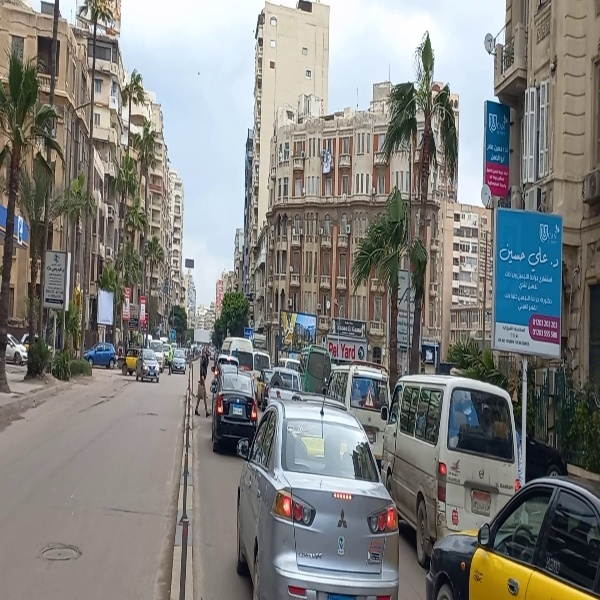

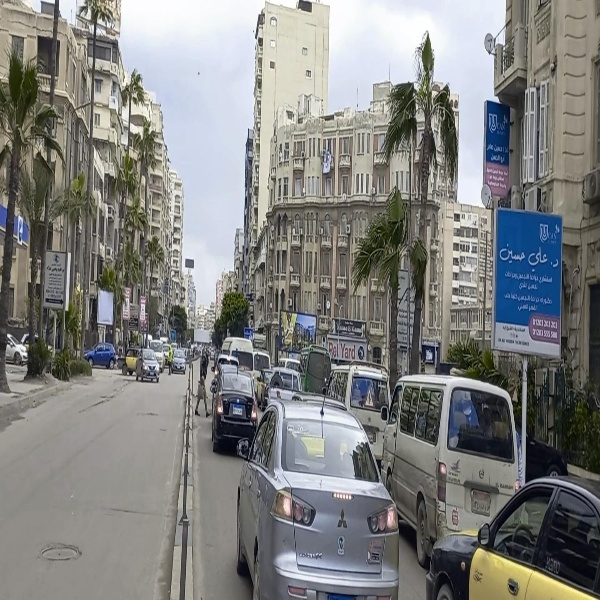

In [ ]:
img = cv2.imread('/content/drive/MyDrive/GANs/ADAS_Dataset/Train_Data/Merged/merged_500.jpg')
input_image = img[:, :600, :] ##original
target_image = img[:, 600:, :] ##target
cv2_imshow(input_image)
cv2_imshow(target_image)
